In [1]:
# Standard library imports
import os
import zipfile

# Third-party imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Torchvision imports
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights

In [2]:
if torch.cuda.is_available():
    print(f"GPUs Available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"- {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available.")

GPUs Available: 1
- Tesla P100-PCIE-16GB


# Local

In [3]:
# ## Dataset and Directory Configuration
# DATASET_NAME = 'rsna-mil-training'
# JOB_NAME = 'RSNA-ResNet18'
# HPC_DIR = '/media02/tdhoang01/21127112-21127734/data'
# OUTPUT_DIR = '/media02/tdhoang01/python-debugging/rsna/results'

# ZIP_FILE_PATH = os.path.join(HPC_DIR, DATASET_NAME + '.zip')
# CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
# FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
# DICOM_DIR = f'{DATASET_NAME}/'

# ## File Paths
# CSV_PATH = f'{DATASET_NAME}/training_1000_scan_subset.csv'

# ## Image Processing Parameters
# MAX_SLICES = 60
# HEIGHT = 224
# WIDTH = 224

# ## Training Hyperparameters
# BATCH_PATIENTS = 4
# NUM_EPOCHS = 2
# LEARNING_RATE = 1e-4

# ## Dataset Split Ratios
# VAL_SIZE = 0.15
# TEST_SIZE = 0.15

# ## Create Necessary Directories
# os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
# os.makedirs(FIGURES_DIR, exist_ok=True)

# ## Load CSVs from zip
# with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
#     medical_scan_data = pd.read_csv(zip_ref.open(CSV_PATH))

# Kaggle

In [4]:
# Configuration
DATASET_NAME = 'rsna-mil-training'
JOB_NAME = 'RSNA-ResNet50'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/working'

# Directories
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, JOB_NAME, 'figures')
DICOM_DIR = os.path.join(INPUT_DIR, DATASET_NAME, DATASET_NAME)

# File Paths
CSV_PATH = f'{DICOM_DIR}/training_1000_scan_subset.csv'

# Image Processing Parameters
MAX_SLICES = 60
HEIGHT = 512
WIDTH = 512

# Training Hyperparameters
BATCH_PATIENTS = 32
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Dataset Split Ratios
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Create Necessary Directories
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load CSV from Kaggle environment (no need to unzip)
medical_scan_data = pd.read_csv(CSV_PATH)

In [5]:
medical_scan_data.head(1)

,patient_id,study_instance_uid,images,labels,patient_scan_label,metadata
0,ID_2e010e33,ID_bda0f47e84,"['ID_b9035cb1e.dcm', 'ID_0713bed86.dcm', 'ID_5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[{'image_position': '[-125.000, -106.498, 42.7..."


In [6]:
medical_scan_data.columns

Index(['patient_id', 'study_instance_uid', 'images', 'labels',
       'patient_scan_label', 'metadata'],
      dtype='object')

# Local dataset gen.

In [7]:
# class DatasetGenerator(Dataset):
#     def __init__(self, zip_file_path, medical_scan_data, max_slices, height, width):
#         self.zip_file_path = zip_file_path
#         self.medical_scan_data = self._parse_medical_scan_data(medical_scan_data)
#         self.max_slices = max_slices
#         self.height = height
#         self.width = width
#         self.channels = 3
#         self.dicom_paths = self._get_dicom_paths()
#         self.transform = transforms.Compose([
#             transforms.Resize((self.height, self.width))
#         ])

#     def __len__(self):
#         return len(self.dicom_paths)

#     def __getitem__(self, idx):
#         dicom_files, row = self.dicom_paths[idx]

#         # Process DICOM files to get images and labels
#         images, labels = self._process_dicom_files(dicom_files)

#         patient_scan_label = row['patient_scan_label']

#         return self._pad_data(images, labels, patient_scan_label)
    
#     def _parse_medical_scan_data(self, medical_scan_data):
#         medical_scan_data['images'] = medical_scan_data['images'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#         medical_scan_data['labels'] = medical_scan_data['labels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
#         return medical_scan_data

#     def _get_dicom_paths(self):
#         dicom_paths = []
#         with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
#             file_list = zip_ref.namelist()
            
#             for _, row in self.medical_scan_data.iterrows():
#                 patient_id = row['patient_id'].replace("ID_", "")
#                 study_instance_uid = row['study_instance_uid'].replace("ID_", "")
#                 dicom_dir_path = f"{DATASET_NAME}/{patient_id}_{study_instance_uid}"
                
#                 dicom_files = [f for f in file_list if f.startswith(dicom_dir_path) and f.endswith(".dcm")]
#                 if dicom_files:
#                     dicom_paths.append((dicom_files, row))
#                 else:
#                     print(f"No DICOM files found for {dicom_dir_path}.")
        
#         return dicom_paths
    
#     def _process_dicom_files(self, dicom_files):
#         images = []
#         labels = []

#         for _, row in self.medical_scan_data.iterrows():
#             image_list = row['images']
#             if all(os.path.basename(f) in image_list for f in dicom_files) and len(image_list) == len(dicom_files):
#                 labels = row['labels']
#                 if labels:
#                     labels = torch.tensor(labels, dtype=torch.float32)
#                 break

#         with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
#             for dicom_file in dicom_files:
#                 with zip_ref.open(dicom_file) as file:
#                     dicom = pydicom.dcmread(file)
#                     img = self._preprocess_slice(dicom)
#                     images.append(torch.from_numpy(img).float())

#         return torch.stack(images), labels
    
#     def _preprocess_slice(self, dicom):
#         bsb_img = self._bsb_window(dicom)
#         return bsb_img.astype(np.float16)

#     def _pad_data(self, images, labels, patient_scan_label):
#         if images.shape[0] > self.max_slices:
#             # Cut out the last images
#             images = images[:self.max_slices]
#             if isinstance(labels, torch.Tensor):
#                 labels = labels[:self.max_slices]
#             else:
#                 labels = labels[:self.max_slices]
#         elif images.shape[0] < self.max_slices:
#             padding = torch.zeros((self.max_slices - images.shape[0], self.channels, self.height, self.width))
#             images = torch.cat((images, padding), dim=0)
    
#             if isinstance(labels, torch.Tensor):
#                 label_padding = torch.zeros(self.max_slices - labels.shape[0])
#                 labels = torch.cat((labels, label_padding))
#             else:
#                 label_padding = torch.zeros(self.max_slices - len(labels))
#                 labels = torch.cat((torch.tensor(labels), label_padding))
        
#         return images, labels, float(patient_scan_label)
    
#     def _correct_dcm(self, dcm):
#         x = dcm.pixel_array + 1000
#         px_mode = 4096
#         x[x >= px_mode] -= px_mode
#         dcm.PixelData = x.tobytes()
#         dcm.RescaleIntercept = -1000

#     def _window_image(self, dcm, window_center, window_width):
#         if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
#             self._correct_dcm(dcm)

#         img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
#         img_min = window_center - window_width // 2
#         img_max = window_center + window_width // 2
#         img = np.clip(img, img_min, img_max)

#         img_resized = cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)
       
#         return img_resized

#     def _bsb_window(self, dcm):
#         brain_img = self._window_image(dcm, 40, 80)
#         subdural_img = self._window_image(dcm, 80, 200)
#         soft_img = self._window_image(dcm, 40, 380)

#         brain_img_normalized = (brain_img - 0) / 80
#         subdural_img_normalized = (subdural_img - (-20)) / 200
#         soft_img_normalized = (soft_img - (-150)) / 380

#         bsb_img = np.stack([brain_img_normalized, subdural_img_normalized, soft_img_normalized], axis=0)
#         return bsb_img

# # Usage
# dataset = DatasetGenerator(
#     zip_file_path=ZIP_FILE_PATH,
#     medical_scan_data=medical_scan_data,
#     max_slices=MAX_SLICES,
#     height=HEIGHT,
#     width=WIDTH,
# )

# Kaggle dataset gen.

In [8]:
import random


In [9]:
class DatasetGenerator(Dataset):
    def __init__(self, dicom_dir, medical_scan_data, height, width):
        self.dicom_dir = dicom_dir
        self.medical_scan_data = self._parse_medical_scan_data(medical_scan_data)
        self.height = height
        self.width = width
        self.channels = 3
        self.dicom_paths = self._get_dicom_paths()
        self.balanced_indices = self._balance_dataset()

    def __len__(self):
        return len(self.balanced_indices)

    def __getitem__(self, idx):
        patient_idx, image_idx = self.balanced_indices[idx]
        dicom_files, _ = self.dicom_paths[patient_idx]

        # Load and process the specific DICOM file
        dicom_file = dicom_files[image_idx]
        dicom = pydicom.dcmread(dicom_file)
        img = self._preprocess_slice(dicom)

        # Convert the NumPy array to a PyTorch tensor
        img_tensor = torch.from_numpy(img).float()

        # Get the corresponding label
        labels = torch.tensor(self.medical_scan_data.iloc[patient_idx]['labels'], dtype=torch.float32)

        return img_tensor, labels[image_idx]

    def _balance_dataset(self):
        all_indices = []
        positive_indices = []
        negative_indices = []

        for patient_idx, row in enumerate(self.dicom_paths):
            _, patient_data = row
            labels = patient_data['labels']
            for image_idx, label in enumerate(labels):
                if label == 1:
                    positive_indices.append((patient_idx, image_idx))
                else:
                    negative_indices.append((patient_idx, image_idx))

        # Randomly undersample the majority class (0s) to match the minority class (1s)
        num_positive = len(positive_indices)
        balanced_negative_indices = random.sample(negative_indices, num_positive)

        balanced_indices = positive_indices + balanced_negative_indices
        random.shuffle(balanced_indices)

        return balanced_indices

    def _parse_medical_scan_data(self, medical_scan_data):
        medical_scan_data['images'] = medical_scan_data['images'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        medical_scan_data['labels'] = medical_scan_data['labels'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        return medical_scan_data

    def _get_dicom_paths(self):
        dicom_paths = []
        
        for _, row in self.medical_scan_data.iterrows():
            patient_id = row['patient_id'].replace("ID_", "")
            study_instance_uid = row['study_instance_uid'].replace("ID_", "")
            dicom_dir_path = os.path.join(self.dicom_dir, f"{patient_id}_{study_instance_uid}")
            
            if os.path.exists(dicom_dir_path):
                dicom_files = [os.path.join(dicom_dir_path, f) for f in os.listdir(dicom_dir_path) if f.endswith(".dcm")]
                if dicom_files:
                    dicom_paths.append((dicom_files, row))
                else:
                    print(f"No DICOM files found for {dicom_dir_path}.")
            else:
                print(f"DICOM directory does not exist: {dicom_dir_path}")
        
        return dicom_paths

    def _preprocess_slice(self, dicom):
        bsb_img = self._bsb_window(dicom)
        return bsb_img.astype(np.float16)

    def _bsb_window(self, dcm):
        brain_img = self._window_image(dcm, 40, 80)
        subdural_img = self._window_image(dcm, 80, 200)
        soft_img = self._window_image(dcm, 40, 380)

        brain_img_normalized = (brain_img - 0) / 80
        subdural_img_normalized = (subdural_img - (-20)) / 200
        soft_img_normalized = (soft_img - (-150)) / 380

        bsb_img = np.stack([brain_img_normalized, subdural_img_normalized, soft_img_normalized], axis=0)
        return bsb_img

    def _window_image(self, dcm, window_center, window_width):
        img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)

        img_resized = cv2.resize(img, (self.height, self.width), interpolation=cv2.INTER_LINEAR)
       
        return img_resized
    
    def plot_label_distribution(self):
        # Count occurrences of each label in the balanced dataset
        label_counts = {0: 0, 1: 0}
        for patient_idx, image_idx in self.balanced_indices:
            label = self.medical_scan_data.iloc[patient_idx]['labels'][image_idx]
            label_counts[label] += 1

        # Create a bar plot for the distribution of labels
        plt.bar(label_counts.keys(), label_counts.values(), color=['blue', 'orange'])
        plt.ylabel('Count')
        plt.title('Distribution of Labels (Balanced)')

        # Annotate counts on top of each bar
        for label, count in label_counts.items():
            plt.text(label, count, str(count), ha='center', va='bottom')

        plt.xticks(list(label_counts.keys()))
        plt.show()
        
    def verify_dataset_integrity(self):
        print(f"Total number of samples in balanced dataset: {len(self.balanced_indices)}")
        
        # Verify that each index refers to a valid image and label
        for idx in range(len(self)):
            img, label = self[idx]
            assert img.shape == (self.channels, self.height, self.width), f"Mismatch in image shape at index {idx}"
            assert label.shape == (), f"Mismatch in label shape at index {idx}"
            assert label.item() in [0, 1], f"Invalid label value at index {idx}"

        print("Dataset integrity verified. All samples have matching images and labels.")

dataset = DatasetGenerator(
    dicom_dir=DICOM_DIR,
    medical_scan_data=medical_scan_data,
    height=HEIGHT,
    width=WIDTH,
)

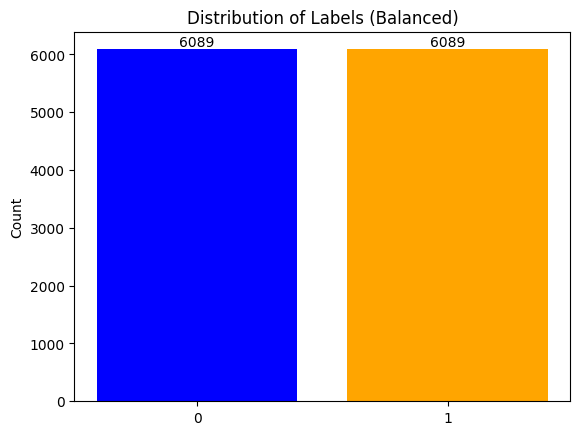

In [10]:
dataset.plot_label_distribution()

In [11]:
print(len(dataset))

12178


# Dataloader

In [12]:
class DataloaderManager:
    def __init__(self, dataset, batch_size, val_size, test_size, num_workers=4):
        self.dataset = dataset
        self.batch_size = batch_size
        self.val_size = val_size
        self.test_size = test_size
        self.num_workers = num_workers
        self.train_loader = None
        self.validate_loader = None
        self.test_loader = None
        self._create_loaders()
        
        # Print lengths after loaders are created
        self.print_lengths()

    def print_dataset_length(self):
        print(f"Total length of dataset: {len(self.dataset)}")

    def print_lengths(self):
        print(f"Length of training dataset: {len(self.train_loader.dataset)}")
        print(f"Length of validation dataset: {len(self.validate_loader.dataset)}")
        print(f"Length of testing dataset: {len(self.test_loader.dataset)}")
    
    def _create_loaders(self):
        # Use balanced indices to get labels for all slices
        labels = [self.dataset.medical_scan_data.iloc[idx[0]]['labels'][idx[1]] for idx in self.dataset.balanced_indices]

        # Adjust val_size relative to train_size
        train_size = 1 - self.test_size - self.val_size
        relative_val_size = self.val_size / (train_size + self.val_size)

        # First split: separate test set
        train_val_indices, test_indices = train_test_split(
            np.arange(len(labels)),
            test_size=self.test_size,
            stratify=labels,
            random_state=42
        )

        # Second split: separate train and validation sets
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=relative_val_size,
            stratify=np.array(labels)[train_val_indices],
            random_state=42
        )

        # Create datasets from selected indices using Subset
        train_dataset = Subset(self.dataset, train_indices)
        val_dataset = Subset(self.dataset, val_indices)
        test_dataset = Subset(self.dataset, test_indices)

        # Create DataLoaders for each set
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
        self.validate_loader = DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)
        self.test_loader = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

In [13]:
dataloader_manager = DataloaderManager(dataset, batch_size=BATCH_PATIENTS, val_size=VAL_SIZE, test_size=TEST_SIZE)

Length of training dataset: 8524
Length of validation dataset: 1827
Length of testing dataset: 1827


# Model configurations

In [14]:
# 2. Model Definition
class ResNet50(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.dropout = nn.Dropout(p=0.3)  # Add dropout layer

    def forward(self, x):
        batch_slices, channels, height, width = x.size()
        return self.dropout(self.resnet(x))
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s]


In [15]:
# 3. Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# mode: Monitors 'min' or 'max' changes in metrics.
# factor: The multiplicative factor for reducing the learning rate. 
##  If the current learning rate is 0.01 and factor=0.5, the new learning rate will be 0.01 * 0.5 = 0.005
# patience: Number of epochs to wait for improvement before reducing the learning rate.

In [16]:
def train(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (image, label) in enumerate(train_loader):
        image, label = image.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(image).squeeze()
        label = label.reshape(-1)

        loss = criterion(output, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted_label = (output > 0.5).float()
        total += label.size(0)
        correct += (predicted_label == label).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}%')

    scheduler.step(epoch_loss)
    return epoch_loss

In [17]:
def validate(model, validate_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(validate_loader):
            image, label = image.to(device), label.to(device)
            
            # Forward pass
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            running_loss += loss.item()
            
            # Calculate accuracy
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
    
    # Calculate average loss and accuracy for validation
    val_loss = running_loss / len(validate_loader)
    accuracy = 100 * correct / total
    
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}%')
    
    return val_loss

In [18]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss):
    checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'checkpoint_epoch_{epoch+1}.pth')    
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")

In [19]:
def load_best_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
    if not checkpoint_files:
        print("No checkpoints found.")
        return None, None

    best_checkpoint = min(checkpoint_files, key=lambda x: float(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, best_checkpoint)
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device), weights_only=True)
    except RuntimeError as e:
        print(f"Error loading checkpoint: {e}")
        print(f"Checkpoint file: {checkpoint_path}")
        print(f"File size: {os.path.getsize(checkpoint_path)} bytes")
        return None, None

    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        epoch = checkpoint['epoch']
        best_val_loss = checkpoint['loss']
        
        print(f"Loaded checkpoint from epoch {epoch+1} with validation loss {best_val_loss}")
        
        return epoch, best_val_loss
    except KeyError as e:
        print(f"Error: Checkpoint file is missing expected data: {e}")
        print(f"Available keys in checkpoint: {checkpoint.keys()}")
        return None, None

In [20]:
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(FIGURES_DIR, 'roc_curve.png'))
    plt.show()
    plt.close()

In [21]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(FIGURES_DIR, 'confusion_matrix.png'))
    plt.show()
    plt.close()

In [22]:
def save_final_model(model, optimizer, scheduler, final_model_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, final_model_path)
    print(f"Final model saved to {final_model_path}")

In [23]:
def evaluate(model, test_loader, device, criterion):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_scores = []
    test_loss = 0

    with torch.no_grad():
        for image, label in test_loader:
            image, label = image.to(device), label.to(device)
            
            output = model(image).squeeze()
            label = label.reshape(-1)
            
            loss = criterion(output, label)
            test_loss += loss.item()
            
            predicted_label = (output > 0.5).float()
            total += label.size(0)
            correct += (predicted_label == label).sum().item()
            
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(predicted_label.cpu().numpy())
            all_scores.extend(output.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Test Accuracy: {accuracy:.4f}%')
    print(f'Test Loss: {avg_loss:.4f}')
    
    plot_roc_curve(np.array(all_labels), np.array(all_scores))
    plot_confusion_matrix(np.array(all_labels), np.array(all_predictions))

    return accuracy, avg_loss

# Main

In [24]:
loaded_epoch, loaded_best_val_loss = load_best_checkpoint(model, optimizer, scheduler, CHECKPOINTS_DIR)

if loaded_epoch is not None:
    start_epoch = loaded_epoch + 1
    best_val_loss = loaded_best_val_loss
else:
    start_epoch = 0
    best_val_loss = float('inf')

for epoch in range(start_epoch, NUM_EPOCHS):
    train_loader = dataloader_manager.train_loader
    validate_loader = dataloader_manager.validate_loader
    
    train_loss = train(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss = validate(model, validate_loader, criterion, device)
    
    if val_loss < best_val_loss:
        save_checkpoint(model, optimizer, scheduler, epoch, val_loss)
        best_val_loss = val_loss

No checkpoints found.
Epoch 1: Loss: 0.6583, Accuracy: 56.2764%
Validation Loss: 0.6121, Validation Accuracy: 59.8248%
Checkpoint saved: /kaggle/working/RSNA-ResNet50/checkpoints/checkpoint_epoch_1.pth
Epoch 2: Loss: 0.6083, Accuracy: 62.2478%
Validation Loss: 0.5773, Validation Accuracy: 64.9699%
Checkpoint saved: /kaggle/working/RSNA-ResNet50/checkpoints/checkpoint_epoch_2.pth
Epoch 3: Loss: 0.5673, Accuracy: 65.9667%
Validation Loss: 0.6071, Validation Accuracy: 66.9951%
Epoch 4: Loss: 0.5249, Accuracy: 69.1107%
Validation Loss: 0.5841, Validation Accuracy: 68.4182%
Epoch 5: Loss: 0.4693, Accuracy: 72.6889%
Validation Loss: 0.5795, Validation Accuracy: 67.4330%
Epoch 6: Loss: 0.4085, Accuracy: 76.2201%
Validation Loss: 0.6955, Validation Accuracy: 65.9004%
Epoch 7: Loss: 0.3495, Accuracy: 79.2586%
Validation Loss: 0.7946, Validation Accuracy: 64.7510%
Epoch 8: Loss: 0.3210, Accuracy: 80.5373%
Validation Loss: 0.7783, Validation Accuracy: 69.0203%
Epoch 9: Loss: 0.2919, Accuracy: 81.

Test Accuracy: 68.6918%
Test Loss: 1.2213


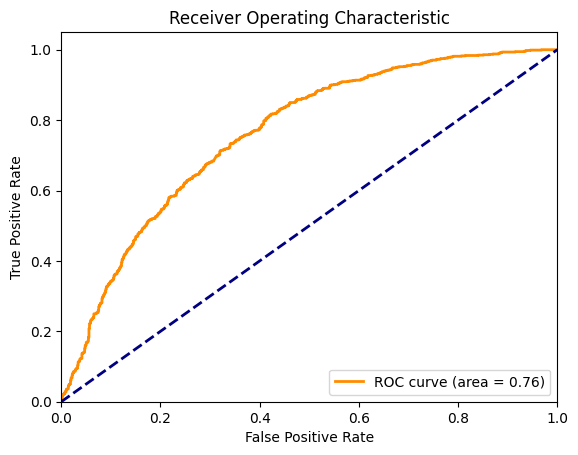

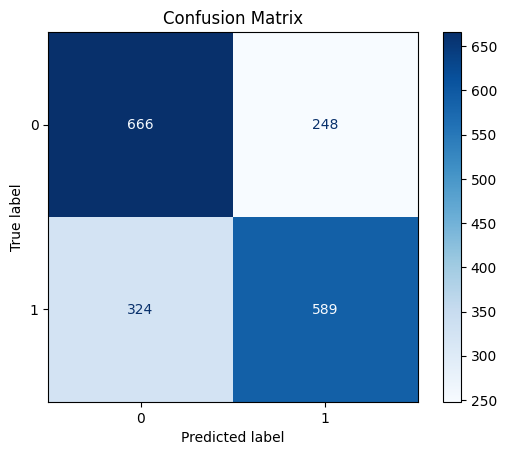

Final model saved to /kaggle/working/RSNA-ResNet50/checkpoints/final_model.pth


In [25]:
test_loader = dataloader_manager.test_loader
accuracy, test_loss = evaluate(model, test_loader, device, criterion)

final_model_path = os.path.join(CHECKPOINTS_DIR, 'final_model.pth')
save_final_model(model, optimizer, scheduler, final_model_path)